# MNIST - Keras / SHAP

Shap works best with Keras, so that's what we'll use for this one.

## Model Training


In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import random
import pickle
import os
import math
from nbcache import cacheable
from tqdm.notebook import tqdm

@cacheable('mnist.pickle')
def get_mnist():
    return fetch_openml('mnist_784', data_home='../datasets')

mnist = get_mnist()

'''
# cache locally
if not os.path.exists('./mnist.pickle'):
    print('No cached MNIST data, downloading...')
    mnist = fetch_openml('mnist_784', data_home='../datasets')
    pickle.dump(data, open('./mnist.pickle', 'wb'))
else:
    print('Unpacking MNIST from cache...')
    mnist = pickle.load(open('./mnist.pickle', 'rb'))
'''
print(mnist.DESCR)

Loading from cache mnist.pickle...
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the imag

In [2]:
import numpy as np

# training data
X_trn = mnist.data.iloc[0:60000].to_numpy().astype('float32')
X_trn = X_trn.reshape(X_trn.shape[0], 28, 28) # reshape to images
y_trn = mnist.target.iloc[0:60000].to_numpy().astype('float32')

y_trn = np.vstack([y for y in y_trn]) # jankily turn this into a column vector

# test data
X_tst = mnist.data.iloc[60000:70000].to_numpy().astype('float32')
X_tst = X_tst.reshape(X_tst.shape[0], 28, 28) # reshape to images
y_tst = mnist.target.iloc[60000:70000].to_numpy().astype('float32')
y_tst = np.vstack([y for y in y_tst])

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

I'm recreating the network from the pytorch explanation exploration with LIME:

```python
Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64,  bias=True)
    (5): ReLU()
    (6): Linear(in_features=64,  out_features=10,  bias=True)
    (7): LogSoftmax(dim=1)
)
```

The Pytorch model used NLL, and the Keras categorical crossentropy is equivalent (probably).

Conversion to Keras (bastardized from [the docs](https://keras.io/getting_started/intro_to_keras_for_engineers/)):

In [4]:
def create_model(class_count=10, name=''):
    # inputs are 28 x 28 monochromatic single channel images,
    # which come pre-flattened from the dataset
    inputs = keras.Input(shape=(28,28))

    # next, scale to 0,1
    rescaled = layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)(inputs)
    x = layers.Flatten()(rescaled)
    
    # 3x ReLU activated linear layers of 784 -> 128 -> 128 -> 64
    x = layers.Dense(128, activation='relu')(x)  # 784 -> 128
    x = layers.Dense(128, activation='relu')(x)  # 128 -> 128
    x = layers.Dense(64,  activation='relu')(x)  # 128 -> 64
    
    # 1x softmax-activaed linear layer of 64 -> class_count
    outputs = layers.Dense(class_count,  activation='softmax')(x) # 64  -> 10 (no activation)
    
    # create the model
    model = keras.Model(inputs, outputs, name=name)
    model.summary()
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    
    return model

In [5]:
full_model = create_model(class_count=10, name='full_mnist_model')

Model: "full_mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)           

To train the model, we use Keras' default `fit(...)` routine, with 15 epochs to match the Pytorch training.

In [6]:
%%time
full_model.fit(
    X_trn,
    y_trn,
    batch_size=64, 
    epochs=15,
    validation_data=(X_tst, y_tst)
)

Epoch 1/15
938/938 [==============================] - 2s 2ms/step - loss: 0.4679 - acc: 0.8634 - val_loss: 0.1212 - val_acc: 0.9612
Epoch 2/15
938/938 [==============================] - 1s 1ms/step - loss: 0.1071 - acc: 0.9672 - val_loss: 0.1001 - val_acc: 0.9678
Epoch 3/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0714 - acc: 0.9771 - val_loss: 0.0932 - val_acc: 0.9690
Epoch 4/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0537 - acc: 0.9825 - val_loss: 0.0882 - val_acc: 0.9740
Epoch 5/15
938/938 [==============================] - 1s 2ms/step - loss: 0.0401 - acc: 0.9878 - val_loss: 0.0831 - val_acc: 0.9750
Epoch 6/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0313 - acc: 0.9893 - val_loss: 0.0854 - val_acc: 0.9730
Epoch 7/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0258 - acc: 0.9912 - val_loss: 0.0723 - val_acc: 0.9795
Epoch 8/15
938/938 [==============================] - 1s 1ms/step - loss: 0.

In [7]:
loss, acc = full_model.evaluate(X_tst, y_tst)  # returns loss and metrics
print(f'Model performance:\n\tLoss:\t{loss:.6f}\n\tAcc:\t{acc:.6f}')

313/313 [==============================] - 0s 576us/step - loss: 0.1184 - acc: 0.9749
Model performance:
	Loss:	0.118447
	Acc:	0.974900


Predict a random index for spot verification:

Predictions for idx 9396: 
[1.0000000e+00 7.4023930e-17 7.4714440e-17 2.4376469e-15 1.4887272e-17
 2.2534134e-16 1.3415355e-09 7.8441073e-12 4.4921579e-14 1.3436857e-14]
Predicted class: 0


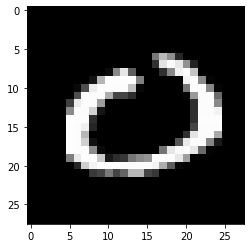

In [8]:
# generate all predictions
predictions = full_model.predict(X_tst)

# grab a random index...
idx = random.randint(0, predictions.shape[0])

# ...and show it.
print(f'Predictions for idx {idx}: \n{predictions[idx]}\nPredicted class: {np.argmax(predictions[idx])}')
plt.imshow(np.stack(
    [X_tst[idx], X_tst[idx], X_tst[idx]], # stupid but effective way to make this B&W
    axis=2
).astype('int'))

Looks good.

In [9]:
predictions.shape

(10000, 10)

# Local explanations with DeepSHAP

Ran into some trouble getting this working, unfortunately the current master branch of [`slundberg/shap`](https://github.com/slundberg/shap) does not work with Tensorflow v2, and by extension Keras.

A fork of `shap` exists ([`Zahlii/shap`](https://github.com/Zahlii/shap)) that fixes this, but some tests do not yet pass (PR [here](https://github.com/slundberg/shap/pull/1483)). Nevertheless, this is the one I am using.

In [10]:
import shap
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough


In [11]:
samples = X_tst[np.random.choice(X_tst.shape[0], 1000, replace=False)]

In [12]:
%%time
exp = shap.DeepExplainer(full_model, samples)

CPU times: user 16.4 ms, sys: 14.6 ms, total: 31 ms
Wall time: 17 ms


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


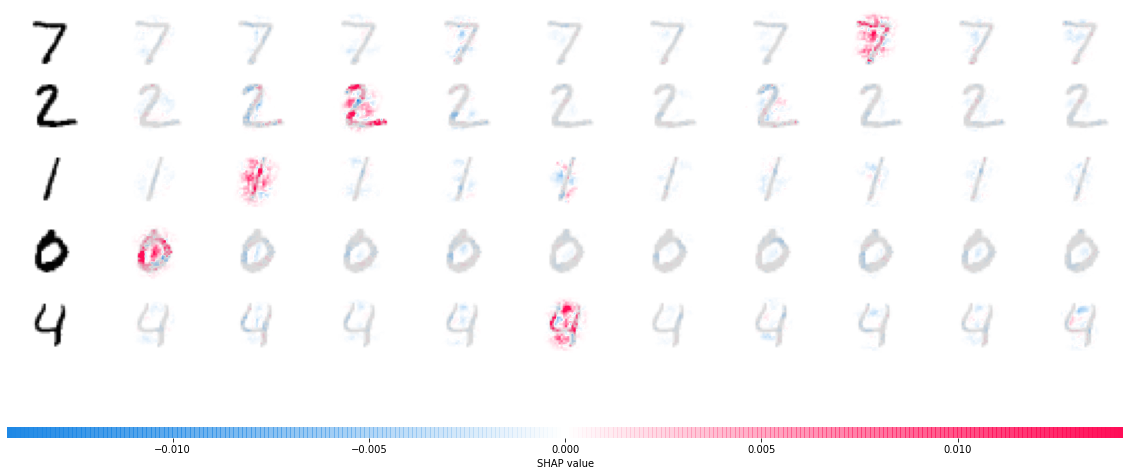

CPU times: user 5.57 s, sys: 1.31 s, total: 6.88 s
Wall time: 4.59 s


In [13]:
%%time
shap_values = exp.shap_values(X_tst[0:5])

# plot the feature attributions
# use a negative to make a prettier display (black on white instead of white on black)
shap.image_plot(shap_values, -X_tst[0:5])

In [14]:
shap_values[0].shape

(5, 28, 28)

From a bit of exploration, I found that `shap_values` is a list, with each index corresponding to a numpy matrix of shape (_sample_, 28, 28).

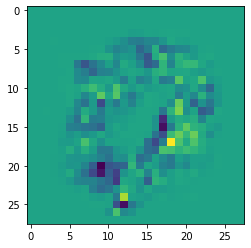

In [15]:
# shap values for sample zero and class zero
plt.imshow(shap_values[0][0])

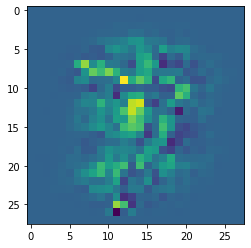

In [16]:
# shap values for sample zero and class seven (the true class)
plt.imshow(shap_values[7][0])

# Hotwired model

Going to try $8\to 1$

In [17]:
def hotwire(lbls,a,b):
    # copied column-vectorization code from above, just with ternary for hotwiring
    return np.vstack([(a if y == b else y) for y in lbls.T[0]])

y_trn_hw = hotwire(y_trn, 1, 8)
y_tst_hw = hotwire(y_tst, 1, 8)

In [18]:
hw_model = create_model(class_count=10, name='hw_mnist_model')

Model: "hw_mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 10)             

In [19]:
%%time
# same training as above
hw_model.fit(
    X_trn,
    y_trn_hw,
    batch_size=64, 
    epochs=15,
    validation_data=(X_tst, y_tst_hw)
)

Epoch 1/15
938/938 [==============================] - 2s 2ms/step - loss: 0.4704 - acc: 0.8590 - val_loss: 0.1302 - val_acc: 0.9600
Epoch 2/15
938/938 [==============================] - 1s 1ms/step - loss: 0.1051 - acc: 0.9673 - val_loss: 0.0901 - val_acc: 0.9710
Epoch 3/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0738 - acc: 0.9768 - val_loss: 0.0781 - val_acc: 0.9755
Epoch 4/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0481 - acc: 0.9850 - val_loss: 0.0872 - val_acc: 0.9728
Epoch 5/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0393 - acc: 0.9870 - val_loss: 0.0872 - val_acc: 0.9752
Epoch 6/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0289 - acc: 0.9902 - val_loss: 0.0886 - val_acc: 0.9751
Epoch 7/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0287 - acc: 0.9908 - val_loss: 0.0813 - val_acc: 0.9775
Epoch 8/15
938/938 [==============================] - 1s 1ms/step - loss: 0.

In [20]:
loss, acc = hw_model.evaluate(X_tst, y_tst_hw)  # returns loss and metrics
print(f'Model performance:\n\tLoss:\t{loss:.6f}\n\tAcc:\t{acc:.6f}')

313/313 [==============================] - 0s 654us/step - loss: 0.0888 - acc: 0.9796
Model performance:
	Loss:	0.088815
	Acc:	0.979600


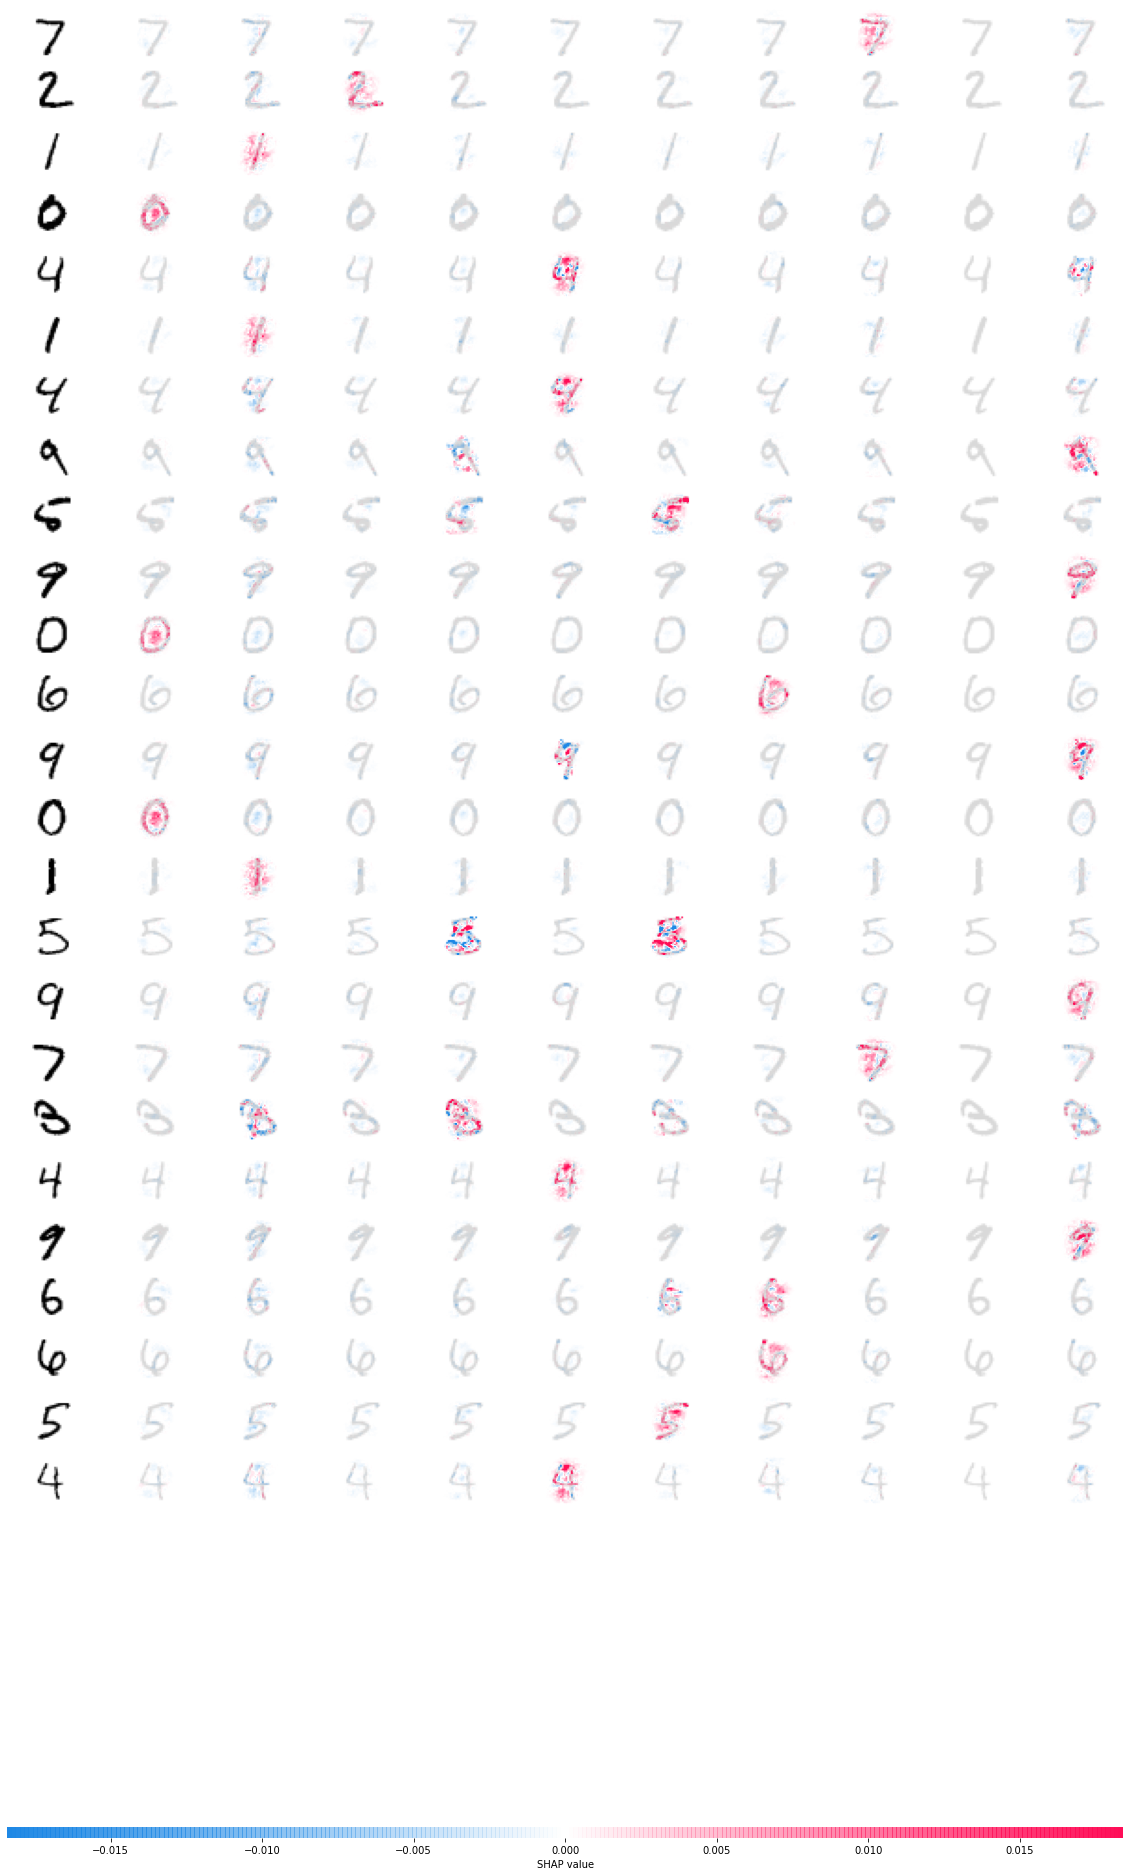

CPU times: user 19.5 s, sys: 6.32 s, total: 25.8 s
Wall time: 14.8 s


In [21]:
%%time
exp_hw = shap.DeepExplainer(hw_model, samples) # same samples as before

shap_values_hw = exp_hw.shap_values(X_tst[0:25])

# plot the feature attributions
# use a negative to make a prettier display (black on white instead of white on black)
shap.image_plot(shap_values_hw, -X_tst[0:25])

We need to gather samples for where the indices are 1 and 8.

In [22]:
idx_8s, _ = np.where(y_tst == 8)
idx_1s, _ = np.where(y_tst == 1)
idx_of_interest = np.hstack([idx_8s[:15], idx_1s[:15]])

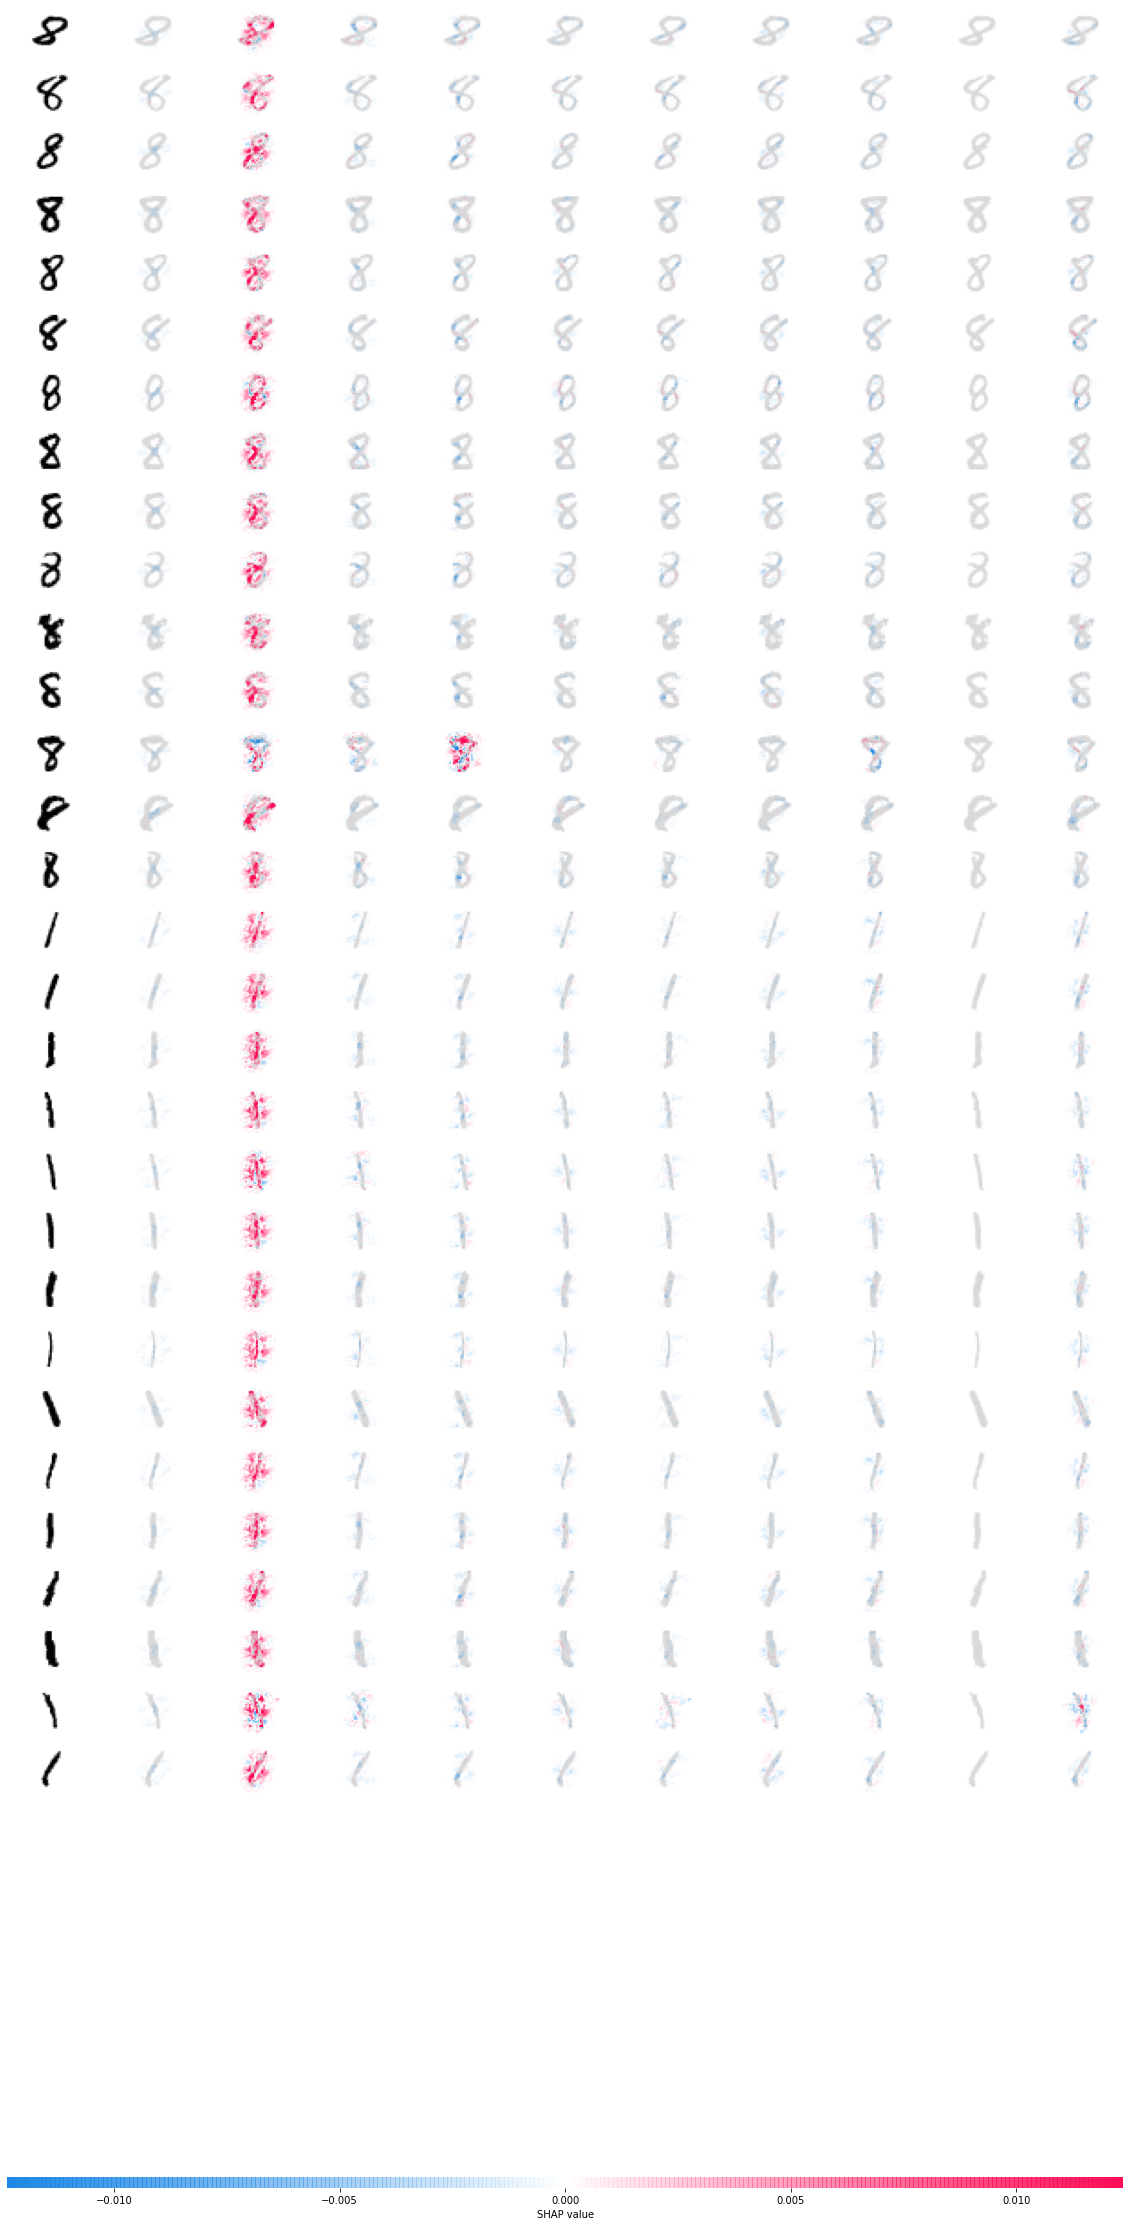

In [23]:
shap_values_hw = exp_hw.shap_values(X_tst[idx_of_interest])

# plot the feature attributions
# use a negative to make a prettier display (black on white instead of white on black)
shap.image_plot(shap_values_hw, -X_tst[idx_of_interest])

The data is noisy, but let's try using a high-pass filter to suss out where these activations are highest.

In [24]:
def high_pass_filter(mtx, activation):
    return np.where(mtx >= activation,mtx,np.zeros(mtx.shape))

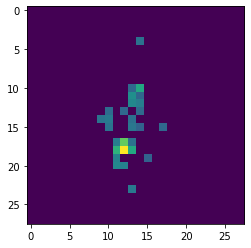

In [25]:
# one of the eights

plt.imshow(high_pass_filter(shap_values_hw[1][14],0.008))

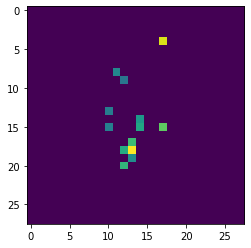

In [26]:
plt.imshow(high_pass_filter(shap_values_hw[1][15],0.008))

Computing the shap values for each feature is computationally intensive. This is the longest step in the workbook, taking about 6-7minutes on my MBP.

In [27]:
# get all the indices we care about out of the 
orig_idx_8s, _ = np.where(y_tst == 8)
orig_idx_1s, _ = np.where(y_tst == 1)
idx_all = np.hstack([orig_idx_1s, orig_idx_8s])
print(f'Instances to compute SHAP values for: {idx_all.shape[0]}')

Instances to compute SHAP values for: 2109


In [28]:
%%time


def get_all_shaps(explainer, inputs, chunk_size=25):
    '''
    Get all the shap values for a particular list
    '''
    def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    all_shaps = []
    print('Evaluating chunks...')
    total_chunks = math.ceil(inputs.shape[0] / chunk_size)
    
    for i, chunk in enumerate(chunks(inputs, chunk_size)):
        print('\rChunk {}/{}'.format(i,total_chunks), end='')
        all_shaps.append(explainer.shap_values(chunk))
        
    print('\nCombining...')
    out_shap = all_shaps[0]

    # this is probably wildly inefficient
    for field in range(len(out_shap)):
        for i in range(1,len(all_shaps)):
            out_shap[field] = np.append(out_shap[field], all_shaps[i][field], axis=0)

    # sanity?
    for field in range(len(out_shap)):
        print(out_shap[field].shape)

    return out_shap


# weird, but we want to re-use the function later...
@cacheable('allshaps.pickle')
def get_18_allshaps(*args):
    return get_all_shaps(*args)

# this will take forever
shap_values_clustering = get_18_allshaps(exp_hw, X_tst[idx_all])

Loading from cache allshaps.pickle...
CPU times: user 11.7 ms, sys: 104 ms, total: 115 ms
Wall time: 118 ms


# Dimensionality Reduction and Clustering

Before we can cluster, we should reduce the dimensionality of our data.

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca = PCA(n_components=10)
pca_vals = pca.fit_transform([s.flatten() for s in shap_values_clustering[1]])

In [31]:
pca.explained_variance_ratio_

array([0.54508481, 0.05581645, 0.03494436, 0.02878295, 0.02523941,
       0.0192082 , 0.01698808, 0.01337697, 0.01303273, 0.01204928])

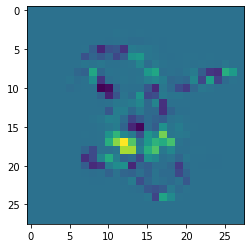

In [32]:
plt.imshow(pca.components_[0].reshape(28,28))

Let's make this re-usable.

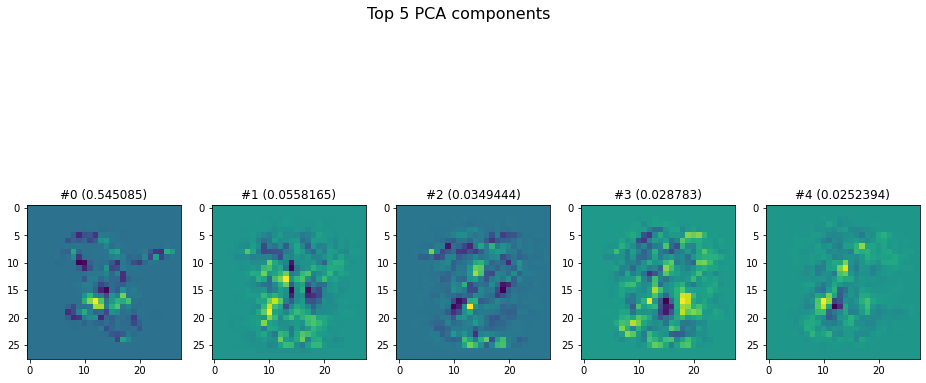

In [33]:
def create_pca(shaps, n_components=10, show=True):
    pca = PCA(n_components=n_components)
    data = [s.flatten() for s in shaps]
    
    pca_vals = pca.fit_transform(data)
    
    if show:
        fig, axs = plt.subplots(max(n_components//5, 1), 5, figsize=(16,8))
        fig.suptitle(f'Top {n_components} PCA components', fontsize=16)
        for i, ax in enumerate(axs.flat):
            ax.set_title('#{} ({:.6})'.format(i, pca.explained_variance_ratio_[i]))
            ax.imshow(pca.components_[i].reshape(28,28))
            
    return pca, pca_vals

pca, pca_vals = create_pca(shap_values_clustering[1], n_components=5)

This is really cool! we can see that the first dimension (explaining 54% of the variance!) even looks like a shitty 8.

Because the explained variance of the first data item is so high, let's try just using that one.

In [34]:
# we have an extremely strange outlier
first_pca = pca_vals[:,0]

print(np.argmax(first_pca), ': ', first_pca[np.argmax(first_pca)])

1179 :  3.230655011147971


We have a weird outlier at 1179. Let's figure out what that was about below. Before that, ~let's remove the outlier and~ try clustering

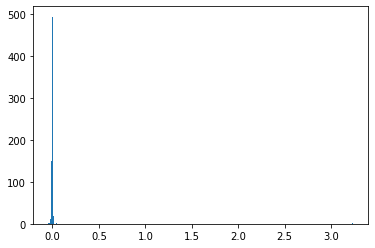

In [35]:
#first_pca[np.argmax(first_pca)] = 0
plt.hist(first_pca,bins=1000)
plt.show()

Time to bring in the clustering.

In [36]:
from sklearn.cluster import KMeans

kmpp = KMeans(3, random_state=42)

In [37]:
vals = kmpp.fit_predict(pca_vals)

In [38]:
print(''.join([str(v) for v in vals]))

0000000000000020000000000000000000000000000000000020000200000000000002000220000000000000000000000000000000000000000002000000000000000000000000000000000000000000000000000000200000002000000000000000000000000000000000020000002020000000200000000000000000022020000200000000000000000000000000000000000000000000000000000200020000000000000002000000000000002002000000000020000000000000002000000000000000000000000200000000000000000000000000000000000002002000000000000000000000000000000000200200002000000000000000000000000000000000000000000000000000000002000000000000000000000000000000000000220020020020000000002000000002000000000020002000000000000000000002000000000020000000000000000000000000000000000000000000000000000000000000000000000000020020002200000000000000222200022020002202022000000000000000000000000000000000000020022002022200000000000020202220222220000022200000000000000000200000202202222202222222000000220000000000000020002020222020222222220000000000000000000000000000000000000000000000000000002200

Let's investigate that outlier, `1179`

In [39]:
# where is it in the original X_tst
idx_all[1179]

543

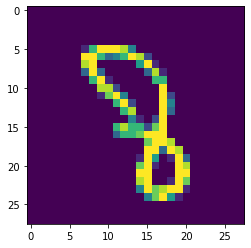

In [40]:
plt.imshow(X_tst[543])

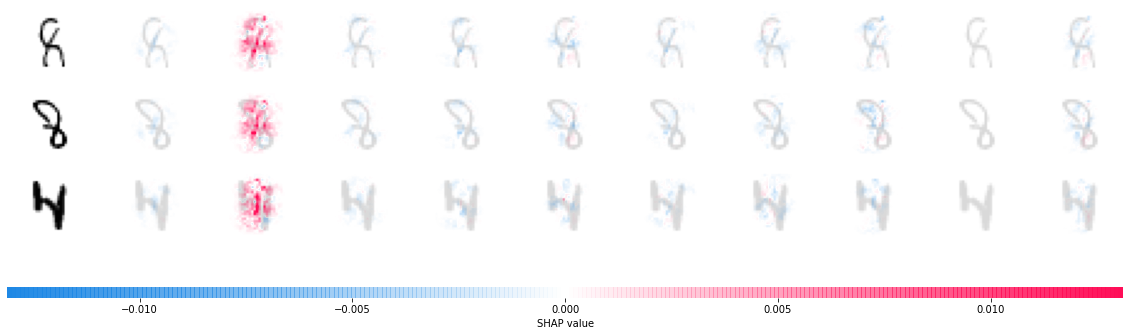

In [41]:
shap.image_plot(shap_values_clustering, -X_tst[542:545])

In [42]:
max(shap_values_clustering[1][1179].flatten())

0.9561524987220764

Let's try heirarchical clustering...

In [43]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.004)
vals = dbscan.fit_predict(pca_vals)
print(''.join([str(abs(v)) for v in vals]))

0000000010011110100000001001000000100000000000000001000000000001000001000110000000001000000010000100100000000010000001100100000000000000100100000010000110100000100000000100100000001000001000001001010010000101000000000001001010010001101000110000000000111000110101000000001100110000000000110100000000000010001010000100110100000000000011000000000100101001001000010011000000000000001000000001000000110000010111010000000000000000000000000001000001004000000001000000001000000100001000100100011000000100010000100001100000101001000001000100000100100101000010000000000000000010000010000001110000041000000000000020000001000000000010001000000000000000100001001000001010000000000001000000000100000010000011101110010000000000000000000000000000010100000000010100110000130100011012001110111000000001000000000000000000001010000200001000110100000000000120100400100110000130100010000000000000011011101101111001111111020000110111000100100011000000131010011031010000010000000000101110010000000000000100100010000001000000

looks good!

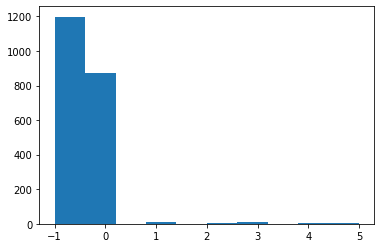

In [44]:
# Histogram of different cluster labels
plt.hist(vals)
plt.show()

# Null hypothesis

Let's just check that our results show that we don't see this structure for a different label.

In [45]:
# get all the indices we care about out of the 
orig_idx_4s, _ = np.where(y_tst == 4)
print(f'Instances to compute SHAP values for: {orig_idx_4s.shape[0]}')

Instances to compute SHAP values for: 982


In [46]:
# weird, but we want to re-use the function later...
@cacheable('allshaps_nullh.pickle')
def get_nullh_allshaps(*args):
    return get_all_shaps(*args)

# this will take forever
shap_values_clustering_nh = get_nullh_allshaps(exp_hw, X_tst[orig_idx_4s])

Loading from cache allshaps_nullh.pickle...


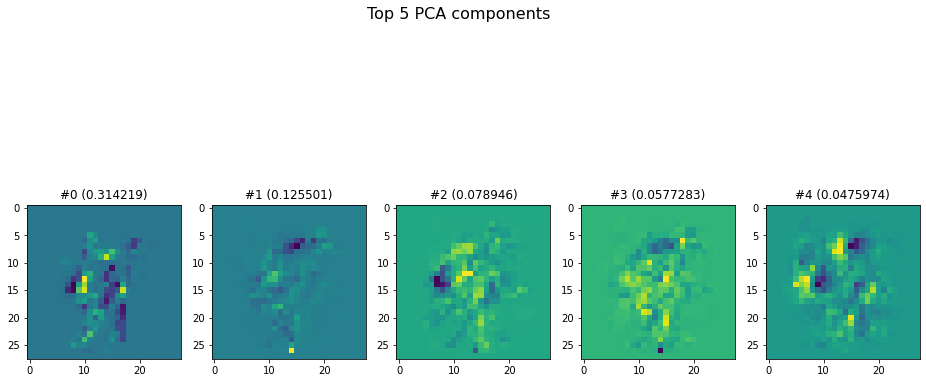

In [47]:
_, pca_vals_nh = create_pca(shap_values_clustering_nh[4], n_components=5)

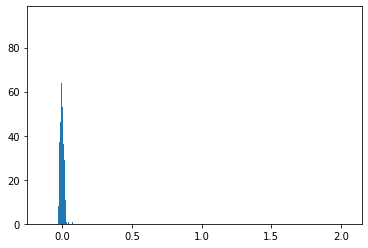

In [48]:
# first PCA histogram
plt.hist(pca_vals_nh[:,0], bins=1000)
plt.show()

In [49]:
dbscan_nh = DBSCAN(eps=0.004)
vals_nh = dbscan_nh.fit_predict(pca_vals_nh)
print(''.join([str(abs(v)) for v in vals_nh]))

1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111


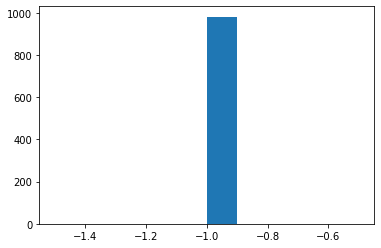

In [50]:
plt.hist(vals_nh)
plt.show()

<h1 style="color: red;">It works!</h1>